In [1]:
# load packages
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib



%matplotlib inline 
 
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
ws=Workspace.from_config()

In [3]:
exp = Experiment(workspace=ws, name='kagglefraud')
run = exp.start_logging()                   
run.log("Experiment start time", str(datetime.datetime.now()))

In [4]:
# import data
creditcard = pd.read_csv("kaggle_fraud_creditcard.csv")
# preprocess
creditcard['Amount'] = StandardScaler().fit_transform(creditcard['Amount'].values.reshape(-1,1)) 
creditcard['Time'] = StandardScaler().fit_transform(creditcard['Time'].values.reshape(-1,1)) 
# store features and target seperately
X = creditcard.drop('Class', axis=1)
y = creditcard['Class']
# split training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
# train a logistic regression classifier 
classifer = LogisticRegression(solver="lbfgs").fit(X_train, y_train)

In [6]:
# predict probabilities on the test data
prediction_proba = classifer.predict_proba(X_test)

In [7]:
# compute roc curve
fpr, tpr, threshold = roc_curve(y_test, prediction_proba[:, 1])
roc_auc = auc(fpr, tpr)

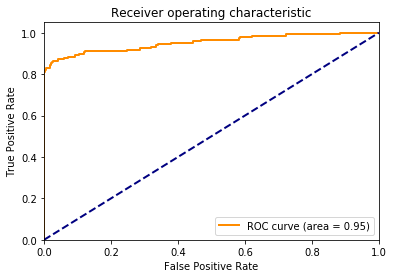

In [8]:
# draw roc curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# find the optimal probability cutoff, which is the intersection point of sensitivity plot and specificity plot
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
cutoff = roc_t["threshold"].values[0]
print("optimal probability cutoff: %.6f" % cutoff)

optimal probability cutoff: 0.000835


In [10]:
# perform predictions based on the probability cutoff
prediction = np.where(prediction_proba[:, 1]>=cutoff, 1, 0)

In [11]:
# compute performance measures
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
# type I error
type_I_error = float(fp) / (fp+tn)
# type II error
type_II_error = float(fn) / (fn+tp)
# accuracy
accuracy = accuracy_score(y_test, prediction)
# f1 score
f1 = f1_score(y_test, prediction)

In [12]:
print("Type I Error: %.2f%%" % (type_I_error*100))
print("Type II Error: %.2f%%" % (type_II_error*100))
print("Accuracy: %.2f%%" % (accuracy*100))
print("F1 Score: %.6f" % f1)

Type I Error: 10.49%
Type II Error: 10.81%
Accuracy: 89.51%
F1 Score: 0.028612


In [13]:
filename = 'kaggle_fraud_model.pkl'
joblib.dump(classifer, filename)

['kaggle_fraud_model.pkl']

In [14]:
run.log("Experiment end time", str(datetime.datetime.now()))
run.complete()

In [15]:
model = Model.register(model_path = "kaggle_fraud_model.pkl",
                       model_name = "kaggle_fraud_model",
                       description = "Kaggle Fraud Detection",
                       workspace = ws)

modelenv = CondaDependencies()
modelenv.add_conda_package("scikit-learn")
 
with open("modelenv.yml","w") as f:
    f.write(modelenv.serialize_to_string())
with open("modelenv.yml","r") as f:
    print(f.read())

Registering model kaggle_fraud_model
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



In [20]:
%%writefile score.py

import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from azureml.core.model import Model
 
def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('kaggle_fraud_model')
    model = joblib.load(model_path)
 
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_proba = model.predict_proba(data)[:, 1]
    if y_proba > 0.000835:
        y_pred = "Fraud"
    else:
        y_pred = "Not Fraud"
    return json.dumps(y_pred)

Overwriting score.py


In [22]:
%%time
 
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="modelenv.yml")

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "kaggle_fraud",  "method" : "sklearn"}, 
                                               description='Kaggle Fraud Detection')
 
service = Webservice.deploy_from_model(workspace=ws,
                                       name='kaggle-fraud-svc4',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)
 
service.wait_for_deployment(show_output=True)


print(service.scoring_uri)

Creating image

Image creation operation finished for image kaggle-fraud-svc4:1, operation "Succeeded"
Creating service
Running....................
SucceededACI service creation operation finished, operation "Succeeded"
http://01479f65-2f69-4759-8c5d-1fa62c4cc3b3.eastus.azurecontainer.io/score
CPU times: user 3.14 s, sys: 310 ms, total: 3.45 s
Wall time: 6min 26s


In [58]:
fraud_example = list(np.array(X_test.iloc[355, :]))
print("X values: ", fraud_example)
print("\ntrue label (1 denoting fraud and 0 denoting nonfraud): ", y_test.iloc[355])

X values:  [-1.1245112280362188, -15.140449622507301, 7.3780424122128405, -16.356367356494, 9.19493491430021, -13.4661632895942, -2.9584305008210294, -16.1655386244192, 10.075253945553198, -7.90182112627786, -13.0094028057641, 4.82823533219729, -11.0584014244364, 1.99812557552295, -8.59204740189288, 0.540385309176116, -10.6157452968661, -21.0178983428443, -8.39739305199317, 3.18355894967976, -1.6914819878255303, 3.14742810473234, 0.34167759507120604, -1.1501624708995202, 0.7951897349649459, -0.194542181109758, 0.145963568626439, -2.4586803475657404, -1.18988788135128, 0.0727666909972656]

true label (1 denoting fraud and 0 denoting nonfraud):  1


In [59]:
nonfraud_example = list(np.array(X_test.iloc[0, :]))
print("X values:", nonfraud_example)
print("\ntrue label (1 denoting fraud and 0 denoting nonfraud): ", y_test.iloc[0])

X values: [0.6839643198001779, -2.53733124088052, 1.89086398954169, -0.8405545387893091, -1.10275857451177, -2.1057249650181697, 0.36781082317464897, -2.7378443184627, -3.5433138803995097, -0.48314658550283, 0.11272408214417098, -1.6125864643408, 0.6358552717405961, 0.40687115041485705, 0.8543712685868969, 0.505753382304214, -0.947788092588628, 0.557331097060658, 1.54663826513625, -0.789047413329509, -1.9596112476146101, 4.32816481557604, -2.16732949946179, 1.02256725061431, -0.241143274477121, -1.09488536686343, -0.47542743748854294, -0.177157043721632, -0.0826905453531387, -0.20370096931354403]

true label (1 denoting fraud and 0 denoting nonfraud):  0


In [60]:
import requests
url = 'http://01479f65-2f69-4759-8c5d-1fa62c4cc3b3.eastus.azurecontainer.io/score'

In [61]:
r = requests.get(url, params={'data': '['+str(fraud_example)+']'})
print(r.text)

"\"Fraud\""


In [62]:
r = requests.get(url, params={'data': '['+str(nonfraud_example)+']'})
print(r.text)

"\"Not Fraud\""
